# datashader

Die Stärke von Bokeh ist, Daten aus Python (oder R) im Webbrowser zu rendern. Aufgrund der Art und Weise, wie Webbrowser entworfen wurden, gibt es Einschränkungen, wie viele Daten auf diese Weise angezeigt werden können. Die meisten Webbrowser können bis zu 100.000 oder 200.000 Datenpunkte in einem Bokeh-Diagramm verarbeiten, bevor sie langsamer werden oder Speicherprobleme haben.

Die [datashader](https://datashader.org/)-Bibliothek soll Bokeh insofern erweitern, dass auch die Visualisierung für sehr große Datensätze möglich werden soll indem die getreue Darstellung der Gesamtverteilung gewährleistet werden soll, nicht jeodch einzelne Datenpunkte. datashader wird installiert mit

```
$ pipenv install datashader
```

## Wann soll Datashader nicht verwendet werden?

* zum Zeichnen von weniger als 100.000 Datenpunkten
* wenn jeder Datenpunkt wichtig ist – die Standard-Bokeh gibt alle Datenpunkte wieder, nicht jedoch zusammen mit `datashader`
* für volle Interaktivität (`hover`-Tools) mit jedem Datenpunkt

## Wann soll Datashader verwendet werden?

* tatsächlich große Daten; wenn Bokeh/Matplotlib Probleme machen
* wenn die Verteilung bedeutender ist als einzelne Datenpunkte
* wenn im Wesentlichen die Verteilung analysiert werden soll

## Wie funktioniert Datashader?

* Tools wie Bokeh ordnen Daten direkt in ein HTML/JavaScript-Diagramm ein
* Datashader stellt Daten in ein Aggregate-Array in Bildschirmgröße dar, aus dem ein Bild erstellt und in ein Bokeh-Diagramm eingebettet werden kann
* mur das Bild mit fester Größe muss an den Browser gesendet werden, sodass Millionen oder Milliarden von Datenpunkten verwendet werden können
* keder Schritt passt sich automatisch an die Daten an, kann aber angepasst werden

## Vom Datashader unterstützte Visualisierungen

Datashader unterstützt derzeit

* Scatterplots/Heatmaps
* Zeitfolgen
* Line Plots
* Raster

In jedem Fall kann die Ausgabe problemlos in Bokeh-Diagramme eingebettet werden, wobei interaktives Resampling auf Schwenk- und Zoombereich, in Notebooks oder Apps erfolgt. Legenden und Hover-Informationen können aus den Aggregat-Arrays generiert werden um Interaktivität zu ermöglichen.

## Big Data originalgetreu visualisieren

Wenn die Daten so groß sind, dass einzelne Punkte nicht leicht zu erkennen sind, ist es entscheidend, dass die Visualisierung prinzipiell erstellt wird und die zugrunde liegende Verteilung für Ihr visuelles System getreu aufzeigt. Zum Beispiel zeigen alle diese Diagramme die gleichen Daten, aber ist eine von ihnen auch die tatsächliche Verteilung?

In [1]:
import pandas as pd
import numpy as np

np.random.seed(1)
num=10000

dists = {cat: pd.DataFrame(dict(x=np.random.normal(x,s,num),
                                y=np.random.normal(y,s,num),
                                val=val,cat=cat))
         for x,y,s,val,cat in 
         [(2,2,0.01,10,"d1"), (2,-2,0.1,20,"d2"), (-2,-2,0.5,30,"d3"), (-2,2,1.0,40,"d4"), (0,0,3,50,"d5")]}

df = pd.concat(dists,ignore_index=True)
df["cat"]=df["cat"].astype("category")
df.tail()

,x,y,val,cat
49995,-1.397579,0.610189,50,d5
49996,-2.649610,3.080821,50,d5
49997,1.933360,0.243676,50,d5
49998,4.306374,1.032139,50,d5
49999,-0.493567,-2.242669,50,d5


Hier haben wir 50000 Punkte, 10000 in jeder von fünf Kategorien mit zugehörigen numerischen Werten. Diese Datenmenge kann nur langsam mit Bokeh oder ähnlichen Bibliotheken geplottet werden, da die vollständigen Daten zum Webbrowser über‐ tragen werden müssen. Darüber zeigen sich beim Plotten von Daten dieser Größe mit Standardansätzen einige Probleme:

* Plot A leidet an *overplotting*, wobei die Verteilung durch später geplottete Datenpunkte verdeckt wird.
* Plot B verwendet kleinere Punkte, um ein Überplotten zu vermeiden, leidet jedoch an Übersättigung, wobei Unter‐ schiede in der Datenpunktdichte nicht sichtbar sind, da alle Dichten oberhalb eines bestimmten Wertes als die gleiche reine schwarze Farbe angezeigt werden
* Plot C verwendet Transparenz, um Übersättigung zu vermeiden, leidet jedoch an Untersättigung, wobei die 10.000 Daten‐ punkte in der größten Kategorie (bei `0,0`) überhaupt nicht sichtbar sind.
* Bokeh kann 50.000 Punkte verarbeiten, aber wenn die Daten größer wären, würden diese Darstellungen an *undersampling* leiden, wobei die Verteilung aufgrund zu geringer Datenpunkte in vergrößerten Bereichen nicht sichtbar oder irreführend wird.

![Tücken beim Visualisieren großer Datenmengen](datashader.png)

PlotA und PlotB erfordern auch ein zeitaufwändiges und fehleranfälliges manuelles Anpassen der Parameter, was problematisch ist, wenn die Daten so groß sind, dass die Visualisierung maßgeblich für das Verständnis der Daten wird.
Mit dem Datashader können wir all diese Probleme vermeiden, indem wir die Daten in ein Array rendern, das automatisch den Umfang aller Dimensionen ermöglicht und dann die tatsächliche Verteilung ohne Parameteranpassung und mit sehr wenig Code anzeigt:

CPU times: user 631 ms, sys: 24.3 ms, total: 655 ms
Wall time: 666 ms


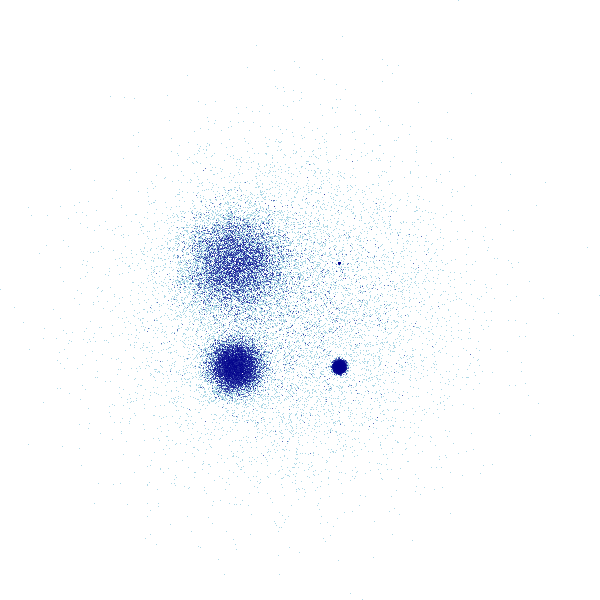

In [2]:
import datashader as ds
import datashader.transfer_functions as tf
%time tf.shade(ds.Canvas().points(df,'x','y'))

## Projektion und Aggregation

In den ersten Schritten der Datashader-Pipeline wird die Auswahl getroffen
* welche Variablen auf der X- und Y-Achse dargestellt werden sollen
* in welcher Größe die Werte zusammengefasst werden sollen
* welchen Wertebereich das Array abdecken sollte
* welche Funktion zum Aggregieren verwendet werden soll

In [3]:
canvas = ds.Canvas(plot_width=250, plot_height=250, x_range=(-4,4), y_range=(-4,4))
agg = canvas.points(df, 'x', 'y', agg=ds.count())
agg

<xarray.DataArray (y: 250, x: 250)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * x        (x) float64 -3.984 -3.952 -3.92 -3.888 ... 3.888 3.92 3.952 3.984
  * y        (y) float64 -3.984 -3.952 -3.92 -3.888 ... 3.888 3.92 3.952 3.984

Hier legen wir fest, dass die Spalten x und y auf die x- und y-Achsen gemappt und mit `count` aggregiert werden sollen. Dies führt zu einem 2D-[xarray](http://xarray.pydata.org/en/stable/) der angeforderten Größe, das einen Wert für jedes mögliche Pixel enthält und die Anzahl der Datenpunkte zählt, die diesem zugeordnet wurden. Ein xarray ähnelt einer Numpy- oder Pandas-Datenstruktur und unterstützt ähnliche Operationen, ermöglicht jedoch beliebige mehrdimensionale Daten.

Zu den verfügbaren Reduktionsfunktionen, die zum Aggregieren verwendet werden können, gehören:

* `count()`: ganzzahlige Anzahl von Datenpunkten für jedes Pixel (Standardeinstellung)
* `any()`: für jeden Datenpunkt ein Pixel, sonst `0`
* `sum(column)`: Gesamtwert der angegebenen Spalte für alle Datenpunkte in diesem Pixel
* `count_cat(column)`: Anzahl von Datenpunkten per Kategorie anhand der angegebenen kategorialen Spalte, die mit Pandas [Categorical data](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html)-Typ deklariert werden muss

## Transformation

Sobald Daten in der Xarray-Aggregatform vorliegen, können sie auf verschiedene Arten verarbeitet werden, wodurch Datashader noch flexibler und leistungsfähiger wird. Anstatt alle Daten aufzuzeichnen, können wir zum Beispiel nur die Anzahl der 99. Perzentile darstellen:

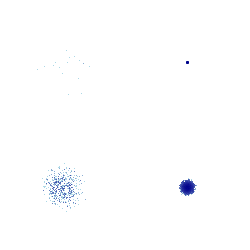

In [4]:
tf.shade(agg.where(agg>=np.percentile(agg,99)))

## Colormapping

Die Werte in einem Array aggregierter Daten können in Pixelfarben konvertiert werden. Dabei unterstützt Datashader jede Bokeh-Palette oder Liste von Farben:

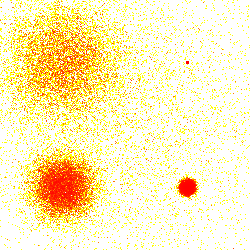

In [5]:
tf.shade(agg, cmap=["yellow", "red"])

Wir können auch wählen, wie die Datenwerte in Farben abgebildet werden sollen:
* `linear`
* `log`
* `eq_hist`

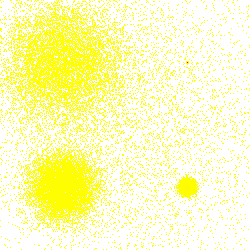

In [6]:
tf.shade(agg,cmap=["yellow", "red"],how='linear')

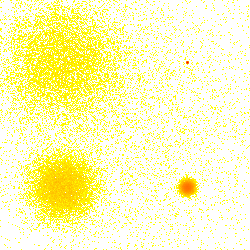

In [7]:
tf.shade(agg,cmap=["yellow", "red"],how='log')

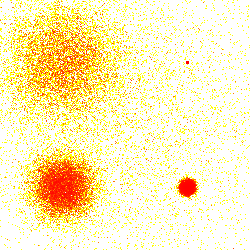

In [8]:
tf.shade(agg,cmap=["yellow", "red"],how='eq_hist')

Bei `linear` wird rot nur für das einzelne Pixel mit der höchsten Dichte verwendet. Das `log`-Mapping weist ähnliche Probleme auf, ist jedoch weniger schwerwiegend, da ein breiter Bereich von Datenwerten gelb abgebildet wird. Die Einstellung `eq_hist` (Standard) vermittelt korrekt die Dichteunterschiede zwischen den verschiedenen Verteilungen, indem das Histogramm der Pixelwerte so abgeglichen wird, dass jede Pixelfarbe gleich häufig verwendet wird.

Bei mehreren Kategorien können auch die einzelnen Aggregate eingefärbt werden:

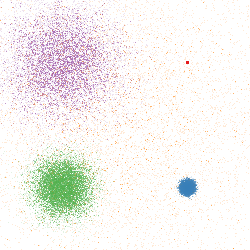

In [9]:
color_key = dict(d1='blue', d2='green', d3='yellow', d4='orange', d5='red')
aggc = canvas.points(df, 'x', 'y', ds.count_cat('cat'))
tf.shade(aggc, color_key)

Wenn die Punkte zu klein erscheinen, könnt ihr sie mit spreading im endgültigen Bild vergrößern.

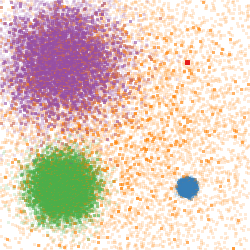

In [10]:
tf.spread(tf.shade(aggc, color_key))

`tf.spread` verwendet eine feste (wenn auch konfigurierbare) Ausbreitungsgröße, während ein ähnlicher Befehl `tf.dynspread` unterschiedlich verteilt, abhängig von der Plotdichte in dieser Ansicht.

## Einbetten

Die von Datashader erzeugten Bilder können mit jedem Plot- oder Anzeigeprogramm verwendet werden. Bokeh bietet darüberhinaus interaktives Zoomen und Verschieben, um auch extrem große Datensätze zu untersuchen. Wir müssen nur die obigen Befehle in eine Callback-Funktion einbinden und sie dann einer Bokeh-`figure` hinzufügen:

In [11]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(-5,5), y_range=(-5,5))

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat('cat'))
    img = tf.shade(agg, color_key)
    return tf.dynspread(img, threshold=0.25)

InteractiveImage(p, image_callback)

Loading BokehJS ...

Damit könnt ihr jetzt auch die Achsenwerte sehen, die in bloßen Bildern nicht sichtbar sind. Wenn ihr den Zoom aktiviert, werden beliebige Bereiche des Diagramms vergrößert wobei ein neues Datashader-Bild mit dem Callback gerendert und im Diagramm angezeigt wird.

Ihr könnt auch problemlos andere Bokeh-Daten im selben Plot überlagern oder `map`-Tiles für geographische Daten im Web Mercator-Format in den Hintergrund setzen.

Datashader funktioniert ähnlich auch für line-Plots (z.B. Zeitreihen und Trajektorien). So können alle Datenpunkte verwendet werden, ohne selbst eine Unterteilung treffen zu müssen. Es kann auch Rasterdaten (z.B. Satellitenwetterdaten) verwenden, um es in einem angeforderten Grid zu rastern, das dann analysiert oder eingefärbt oder mit anderen Nicht-Rasterdaten kombiniert werden kann. Wenn ihr beispielsweise Höhenangaben in Rasterform und Einkommensdaten als einzelne Punkte habt, könnt ihr leicht alle Pixel zeichnen, bei denen das durchschnittliche Einkommen über einem bestimmten Schwellenwert liegt und die Höhe unter einem bestimmten Wert liegt. Dies wäre mit einem traditionellen Workflow nur sehr schwierig auszudrücken.